In [1]:
import cv2
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
import os
import numpy as np
import random
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
class CnnAutoencoder(nn.Module):
    def __init__(self, scale=2, channel_maps=[], padding=1, kernel_size=3, num_channels=3, img_width=100, img_height=100, device=torch.device("cpu")):
        super().__init__()

        self.device = device

        self.img_width      = img_width
        self.img_height     = img_height
        self.num_channels   = num_channels
        self.kernel_size    = kernel_size
        self.padding        = padding
        self.channel_maps   = channel_maps
        self.scale          = scale

        self.reversed_channel_maps = list(reversed(channel_maps))

        # Build convolutional layers
        self.convolutional_layers = nn.ModuleList([])

        # [3, 16, 4, 8, 4, 8, 8, 4, 8]
        for i in range(len(self.channel_maps) - 1):
            self.convolutional_layers.append(nn.Conv2d(self.channel_maps[i], self.channel_maps[i+1], kernel_size=self.kernel_size, padding=self.padding))

        # Build deconvolutional layers
        self.deconvolutional_layers = nn.ModuleList([])

        for i in range(len(self.reversed_channel_maps) - 1):
            self.deconvolutional_layers.append(nn.ConvTranspose2d(self.reversed_channel_maps[i], self.reversed_channel_maps[i+1], 2, stride=2))

    def conv(self, x):
        for i in range(len(self.convolutional_layers)):
            conv_layer = self.convolutional_layers[i]

            x = F.max_pool2d(F.relu(conv_layer(x)), self.scale)
        
        return x

    def compress(self, x):
        x = self.conv(x)
        x = x.view(-1, x.shape[1] * x.shape[2] * x.shape[3])

        return x

    def deconv(self, x):
        for i in range(len(self.deconvolutional_layers)):
            deconv_layer = self.deconvolutional_layers[i]
            x = deconv_layer(x)

            if i != len(self.deconvolutional_layers) - 1:
                x = F.relu(x)
            else:
                x = torch.sigmoid(x)

        return x

    def forward(self, x):
        x = self.conv(x)
        x = self.deconv(x)

        return x


In [3]:
class CnnAutoencoderDataset(Dataset):
    def __init__(self, img_dir, img_width, img_height):
        self.img_dir    = img_dir
        self.img_width  = img_width
        self.img_height = img_height
        self.images     = os.listdir(img_dir)

        self.dim = (img_width, img_height)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        img_path = os.path.join(self.img_dir, self.images[index])

        img = (cv2.resize(cv2.imread(img_path), self.dim) / 255).transpose((2, 0, 1)) 

        # Input is the Output
        return torch.Tensor(img), torch.Tensor(img)

In [4]:
device         = 'cuda'
gpu_index      = 0
epochs         = 100
learning_rate  = 0.0001
chunk_size     = 1
batch_size     = 1
kernel_size    = 3
model_file     = "/home/ralampay/workspace/pyneural/model-arrest-128-128.pth"
channel_maps   = [3, 16, 8, 4]
padding        = 1
scale          = 2
img_width      = 128
img_height     = 128
img_dir        = "/home/ralampay/workspace/pyneural/output"
num_channels   = 3

In [5]:
if device == 'cuda':
    print("CUDA Device: {}".format(torch.cuda.get_device_name(gpu_index)))
    device = "cuda:{}".format(gpu_index)
    
model = CnnAutoencoder(
    scale=scale,
    channel_maps=channel_maps,
    padding=padding,
    kernel_size=kernel_size,
    num_channels=num_channels,
    img_width=img_width,
    img_height=img_height
).to(device)

state = torch.load(model_file)
model.load_state_dict(state['state_dict'])
model.optimizer = state['optimizer']

CUDA Device: NVIDIA GeForce RTX 3050 Laptop GPU


In [19]:
loss_fn = nn.BCELoss()

images = []
errors = []

dim = (img_width, img_height)

for img_file in os.listdir(img_dir):
    img_path = os.path.join(img_dir, img_file)
    img = (cv2.resize(cv2.imread(img_path), dim) / 255).astype('float32')
    
    raw = img.transpose((2, 0, 1))
    
    original_input = torch.Tensor(np.array([raw])).float().to(device)
    predictions    = model(original_input)
    
    losses = loss_fn(predictions, original_input)
    
    errors.append(losses.item())

errors = np.array(errors)
min_loss = np.min(errors)
max_loss = np.max(errors)

print("Min Loss: {}".format(min_loss))
print("Max Loss: {}".format(max_loss))

Min Loss: 0.4098656177520752
Max Loss: 0.42057985067367554


In [21]:
rs_scores = []

for error in errors:
    s = 1 - ((error - min_loss) / max_loss)
    
    rs_scores.append(s)

frame_index = 0
for s in rs_scores:
    print("Frame {}: {}".format(frame_index, s))
    frame_index += 1

Frame 0: 0.9755827497651343
Frame 1: 0.999140042054041
Frame 2: 0.9924816036600083
Frame 3: 0.9783029974239527
Frame 4: 0.9941558147995248
Frame 5: 0.9792837718084301
Frame 6: 0.9951971036933833
Frame 7: 0.9995446531179357
Frame 8: 0.9998100949822701
Frame 9: 0.9968518991706394
Frame 10: 0.9788973009253334
Frame 11: 0.9754496036724796
Frame 12: 0.978951225447159
Frame 13: 0.9847752863845614
Frame 14: 0.998207027364321
Frame 15: 0.9996193396435653
Frame 16: 0.9834511949064639
Frame 17: 0.9875768105565649
Frame 18: 0.9822513211507847
Frame 19: 0.9995899327098496
Frame 20: 0.9963465959312992
Frame 21: 0.9820364025243762
Frame 22: 0.999731156851766
Frame 23: 0.9846444786745877
Frame 24: 0.9994289386052667
Frame 25: 0.9809747059271199
Frame 26: 0.9870970169464719
Frame 27: 0.9995661237225522
Frame 28: 0.999909724256497
Frame 29: 0.9793849600044443
Frame 30: 0.9788566272387003
Frame 31: 0.9995113488797517
Frame 32: 0.9806289087306564
Frame 33: 0.9939916319912859
Frame 34: 0.9929509808381586


(0.97, 1.0)

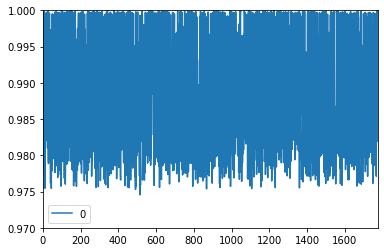

In [43]:
from sklearn import preprocessing

df = pd.DataFrame(rs_scores)


plot = df.plot()
plot.autoscale(enable=True, axis='x', tight=True)
plot.set_ylim(0.97, 1)